In [1]:
import pandas as pd
import numpy as np

In [2]:
# sementara hapus RVH WPW AVBLOCK SABLOCK AFLUT SVT
RESPONSE_COL = ['Sinus', 'Tachy', 'Brady', 'LVH', 'QRSfragmented', 'Lowvoltage', 
                'STEMI','BER', 'Taxis', 'Normal_ECG']

RANDOM_STATE = 42

In [3]:
df = pd.read_csv('valid248resample.csv').drop(columns = 'Unnamed: 0')
df['Sinus'].replace({1:0, 2:1, 3:2}, inplace = True)
df['Tachy'].replace({1:0, 2:1}, inplace = True)
df['Brady'].replace({1:0, 2:1}, inplace = True)
df['STEMI'].replace({1:0, 2:1}, inplace = True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   AF                   1186 non-null   int64
 1   HR                   1186 non-null   int64
 2   HRclass              1186 non-null   int64
 3   Regularity           1186 non-null   int64
 4   Qpath                1186 non-null   int64
 5   Qpathlocation        1186 non-null   int64
 6   STsegment            1186 non-null   int64
 7   STTchanges           1186 non-null   int64
 8   STTiskemia           1186 non-null   int64
 9   STTnonspesific       1186 non-null   int64
 10  STloc                1186 non-null   int64
 11  QTinterval           1186 non-null   int64
 12  QTintervalcorrected  1186 non-null   int64
 13  Twave                1186 non-null   int64
 14  Twaveloc             1186 non-null   int64
 15  Taxisdegree          1186 non-null   int64
 16  VES                  118

In [5]:
from itertools import chain

test_index = []
for col in RESPONSE_COL:
    for label in df[col].unique():
        query = df[col][df[col] == label]
        sample_index = query.sample(n = 4, random_state = RANDOM_STATE, replace = False).index.to_list()
        test_index.append(sample_index)

flatten_test_index = list(chain.from_iterable(test_index))
unique_flatten_test_index = np.unique(flatten_test_index)

train_index = [i for i in range(len(df)) if i not in unique_flatten_test_index]

df_train = df.loc[train_index, :].reset_index(drop=True)
df_test = df.loc[unique_flatten_test_index, :].reset_index(drop=True)

In [6]:
X_train = df_train.loc[:, :'Uwave'].to_numpy()
X_test = df_test.loc[:, :'Uwave'].to_numpy()

In [7]:
y_train = df_train.loc[:, 'Uwave':]
y_test = df_test.loc[:, 'Uwave':]

In [8]:
from tensorflow.keras.utils import to_categorical

def preprocessing(data):
    npy_data = []
    for col in RESPONSE_COL:
        cat = to_categorical(data.loc[:, col])
        npy_data.append(cat)
    return npy_data

In [9]:
npy_train = preprocessing(y_train)
npy_test = preprocessing(y_test)

In [10]:
for i in npy_train:
    print(i.shape)

(1107, 3)
(1107, 2)
(1107, 2)
(1107, 2)
(1107, 2)
(1107, 2)
(1107, 2)
(1107, 2)
(1107, 4)
(1107, 2)


In [11]:
for i in npy_test:
    print(i.shape)

(79, 3)
(79, 2)
(79, 2)
(79, 2)
(79, 2)
(79, 2)
(79, 2)
(79, 2)
(79, 4)
(79, 2)


In [12]:
X_train.shape, X_test.shape

((1107, 20), (79, 20))

In [13]:
import tensorflow as tf
inputs = tf.keras.Input(shape=(X_train.shape[1]))

x1 = tf.keras.layers.Dense(128, activation='relu', kernel_initializer = 'uniform')(inputs)
x1 = tf.keras.layers.Dropout(0.5)(x1)
sin = tf.keras.layers.Dense(3, kernel_initializer = 'uniform', activation = 'softmax', name='Sinus')(x1)

x2 = tf.keras.layers.Dense(128, activation='relu', kernel_initializer = 'uniform')(inputs)
x2 = tf.keras.layers.Dropout(0.5)(x2)
tac = tf.keras.layers.Dense(2, kernel_initializer = 'uniform', activation = 'softmax', name='Tachy')(x2)

x3 = tf.keras.layers.Dense(128, activation='relu', kernel_initializer = 'uniform')(inputs)
x3 = tf.keras.layers.Dropout(0.5)(x3)
bra = tf.keras.layers.Dense(2, kernel_initializer = 'uniform', activation = 'softmax', name='Brady')(x3)

x4 = tf.keras.layers.Dense(128, activation='relu', kernel_initializer = 'uniform')(inputs)
x4 = tf.keras.layers.Dropout(0.5)(x4)
lvh = tf.keras.layers.Dense(2, kernel_initializer = 'uniform', activation = 'softmax', name='LVH')(x4)

x5 = tf.keras.layers.Dense(32, activation = 'relu', kernel_initializer = 'uniform') (inputs)
x5 = tf.keras.layers.Dense(64, activation = 'relu', kernel_initializer = 'uniform') (x5)
x5 = tf.keras.layers.Dense(128, activation = 'relu', kernel_initializer = 'uniform') (x5)
qrs = tf.keras.layers.Dense(2, kernel_initializer = 'uniform', activation = 'softmax', name='QRSfragmented')(x5)

x6 = tf.keras.layers.Dense(32, activation = 'relu', kernel_initializer = 'uniform') (inputs)
x6 = tf.keras.layers.Dense(64, activation = 'relu', kernel_initializer = 'uniform') (x6)
x6 = tf.keras.layers.Dense(128, activation = 'relu', kernel_initializer = 'uniform') (x6)
lvl = tf.keras.layers.Dense(2, kernel_initializer = 'uniform', activation = 'softmax', name='Lowvoltage')(x6)

x7 = tf.keras.layers.Dense(32, activation = 'relu', kernel_initializer = 'uniform') (inputs)
x7 = tf.keras.layers.Dense(64, activation = 'relu', kernel_initializer = 'uniform') (x7)
x7 = tf.keras.layers.Dense(128, activation = 'relu', kernel_initializer = 'uniform') (x7)
stm = tf.keras.layers.Dense(2, kernel_initializer = 'uniform', activation = 'softmax', name='STEMI')(x7)

x8 = tf.keras.layers.Dense(32, activation = 'relu', kernel_initializer = 'uniform') (inputs)
x8 = tf.keras.layers.Dense(64, activation = 'relu', kernel_initializer = 'uniform') (x8)
x8 = tf.keras.layers.Dense(128, activation = 'relu', kernel_initializer = 'uniform') (x8)
ber = tf.keras.layers.Dense(2, kernel_initializer = 'uniform', activation = 'softmax', name='BER')(x8)

x9 = tf.keras.layers.Dense(128, activation='relu', kernel_initializer = 'uniform')(inputs)
x9 = tf.keras.layers.Dropout(0.5)(x9)
txs = tf.keras.layers.Dense(4, kernel_initializer = 'uniform', activation = 'softmax', name='Taxis')(x9)

x0 = tf.keras.layers.Dense(128, activation='relu', kernel_initializer = 'uniform')(inputs)
x0 = tf.keras.layers.Dropout(0.5)(x0)
ecg = tf.keras.layers.Dense(2, kernel_initializer = 'uniform', activation = 'softmax', name='Normal_ECG')(x0)

model = tf.keras.Model(inputs=inputs, outputs=[sin, tac, bra, lvh, qrs, lvl, stm, ber, txs, ecg])
model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer = 'adam'
)

2022-08-24 04:07:44.627856: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-24 04:07:45.092743: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36763 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:bd:00.0, compute capability: 8.0


In [14]:
# model.summary()

In [15]:
from datetime import datetime

h = model.fit(
    x=X_train,
    y=npy_train,
    batch_size=20,
#     validation_split=0.1,
    validation_data=(X_test, npy_test),
    epochs=100,
    verbose=0
)

2022-08-24 04:07:48.337106: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


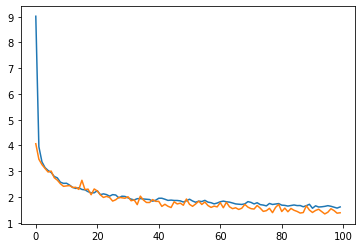

In [16]:
import matplotlib.pyplot as plt

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])

In [17]:
categorical_name = [
    'Sinus', 'Tachy', 'Brady', 'LVH', 'QRSfragmented', 'Lowvoltage', 'STEMI', 'BER', 'Taxis', 'Normal_ECG'
]

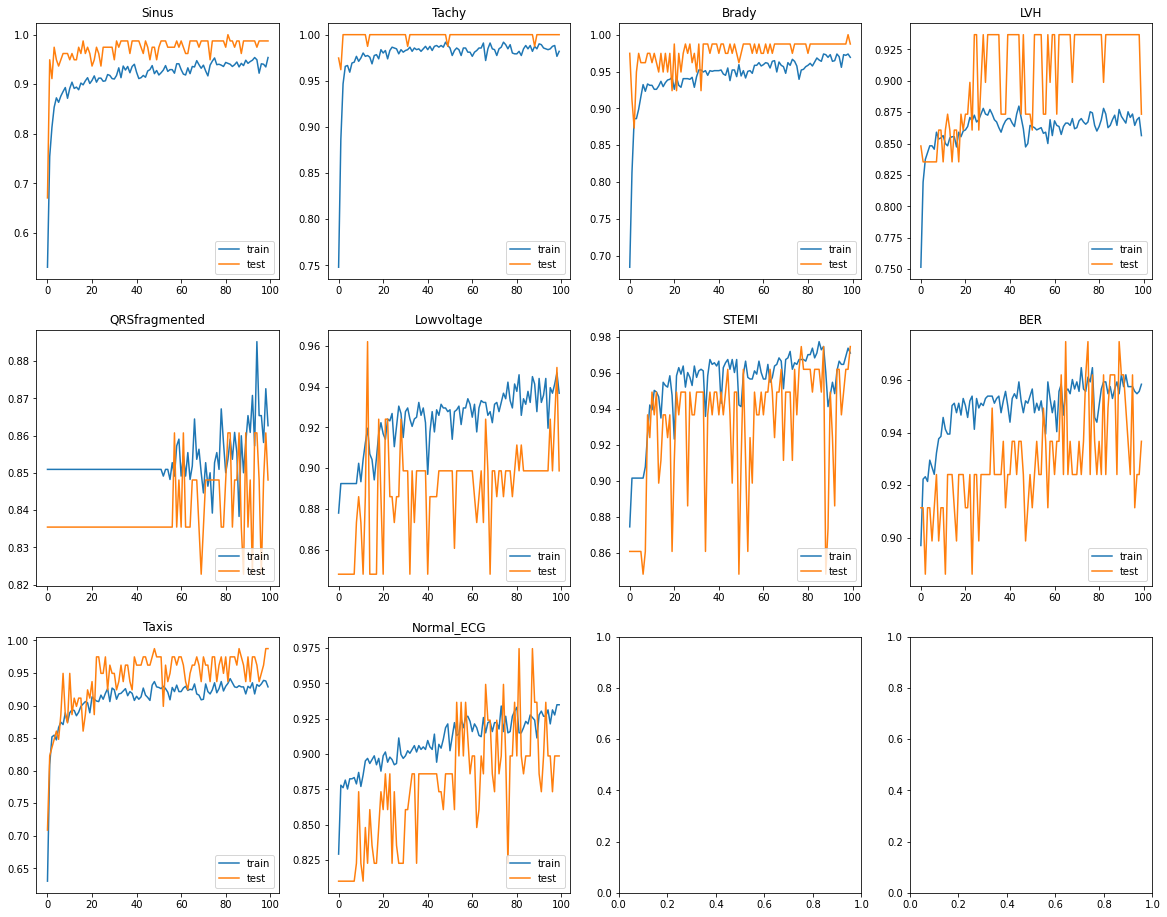

In [18]:
from math import ceil
n_column = 4
n_row = ceil(len(categorical_name) / n_column)

fig = plt.figure(figsize=(20, 16))
axs = fig.subplots(nrows=n_row, ncols=n_column)

i = 0
for j in range(n_row):
    for k in range(n_column):
        try:
            if i == len(categorical_name):
                break
            axs[j, k].plot(h.history[categorical_name[i] + '_accuracy'], label = 'train')
            axs[j, k].plot(h.history['val_' + categorical_name[i] + '_accuracy'], label = 'test')
            axs[j, k].set_title(categorical_name[i])
            axs[j, k].legend(loc ="lower right")
        except KeyError as e:
            pass
        i += 1

In [19]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def categorical_evaluation(actual, pred):
    pred = np.argmax(pred, axis = 1)
    actual = np.argmax(actual, axis = 1)
    
    p = precision_score(actual, pred, average='macro')
    r = recall_score(actual, pred, average='macro')
    f = f1_score(actual, pred, average='macro')

    print("Precision: {}, Recall: {}, F1: {}".format(p, r ,f))

    cm = confusion_matrix(actual, pred)
    sns.heatmap(cm, annot=True, cmap='Blues')

In [20]:
pred = model.predict(X_test)

Precision: 0.991869918699187, Recall: 0.9841269841269842, F1: 0.9877546923617384


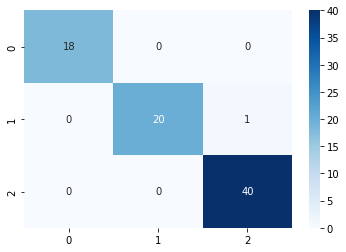

In [21]:
categorical_evaluation(npy_test[0], pred[0])

Precision: 1.0, Recall: 1.0, F1: 1.0


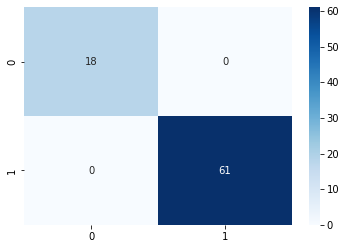

In [22]:
categorical_evaluation(npy_test[1], pred[1])

Precision: 0.9915254237288136, Recall: 0.9761904761904762, F1: 0.9835313737752762


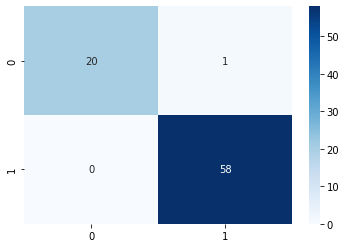

In [23]:
categorical_evaluation(npy_test[2], pred[2])

Precision: 0.9315068493150684, Recall: 0.6875, F1: 0.7359625668449198


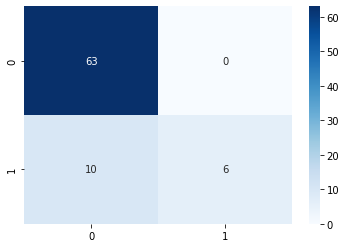

In [24]:
categorical_evaluation(npy_test[3], pred[3])

Precision: 0.7232142857142857, Recall: 0.6311188811188811, F1: 0.6565217391304348


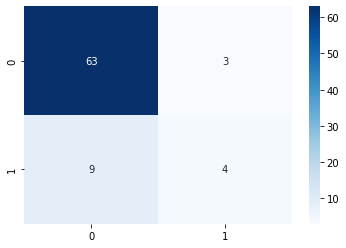

In [25]:
categorical_evaluation(npy_test[4], pred[4])

Precision: 0.9466666666666667, Recall: 0.6666666666666666, F1: 0.721830985915493


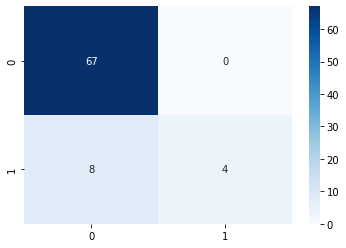

In [26]:
categorical_evaluation(npy_test[5], pred[5])

Precision: 0.9230769230769231, Recall: 0.9852941176470589, F1: 0.9508706467661692


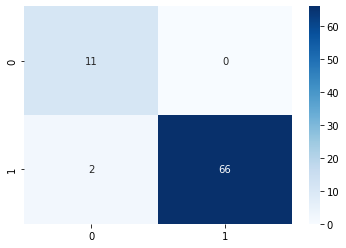

In [27]:
categorical_evaluation(npy_test[6], pred[6])

Precision: 0.8127853881278538, Recall: 0.7718253968253967, F1: 0.7904509283819628


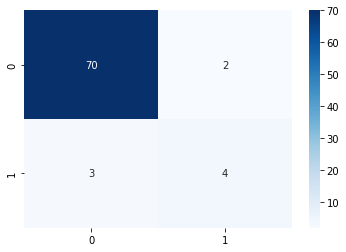

In [28]:
categorical_evaluation(npy_test[7], pred[7])

Precision: 0.9950980392156863, Recall: 0.975, F1: 0.9843668577384054


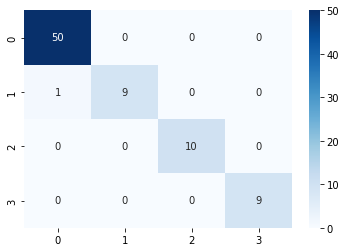

In [29]:
categorical_evaluation(npy_test[8], pred[8])

Precision: 0.9444444444444444, Recall: 0.7333333333333334, F1: 0.7887700534759359


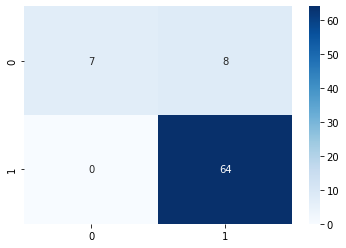

In [30]:
categorical_evaluation(npy_test[9], pred[9])

In [31]:
model.save('my_model.h5')